In [1]:
# Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

import time
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

# pip install langdetect
from langdetect import detect, detect_langs, DetectorFactory

from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.metrics.pairwise import cosine_similarity

import warnings
warnings.filterwarnings("ignore")


In [2]:
# Importing reviews file
reviews = pd.read_csv('../assets/reviews_cleaned.csv')
listings = pd.read_csv('../assets/listings.csv')

reviews

listing_id                  id        date  reviewer_id reviewer_name  \
0           50646            11909864  2014-04-18      1356099         James   
1           50646            13823948  2014-06-05     15222393         Welli   
2           50646            15117222  2014-07-02      5543172         Cyril   
3           50646            15426462  2014-07-08       817532          Jake   
4           50646            15552912  2014-07-11     10942382         Subba   
...           ...                 ...         ...          ...           ...   
35701    53388036  519872316008923135  2021-12-18    304470840           Lai   
35702    53408171  520550850874450074  2021-12-19    433426203        Prerna   
35703    53614218  519195208385672309  2021-12-17    107628510        Fellix   
35704    53679344  516272103489812433  2021-12-13    340715577     Mark Roan   
35705    53717759  514133625594699625  2021-12-10    192227309       Zhengyi   

                                                comments language  
0      A comfortable room in a smart condo developmen...       en  
1      Stayed over at Sujatha's house for  good night...       en  
2      It's been a lovely stay at Sujatha's. The room...       en  
3      We had a great experience. A nice place, an am...       en  
4       Quiet condo. Comfortable stay and good location.       en  
...                                                  ...      ...  
35701  Wei is an amazing host! Quick response from We...       en  
35702               Easy to work with and good apartment       en  
35703  Thank you Lucas and Sandy for having me! Sandy...       en  
35704  Great host and amazing experience. Got the one...       en  
35705  Very good location. However, no amenities like...       en  

[35706 rows x 7 columns]

In [3]:
%%time
# NLTK's VADER uses polarity (positive and negative) and intensity of emotions/words 

# Initial test of VADER
sent = SentimentIntensityAnalyzer()

reviews['scores'] = reviews['comments'].apply(lambda review: sent.polarity_scores(review))

reviews.head()

Wall time: 25.6 s


listing_id        id        date  reviewer_id reviewer_name  \
0       50646  11909864  2014-04-18      1356099         James   
1       50646  13823948  2014-06-05     15222393         Welli   
2       50646  15117222  2014-07-02      5543172         Cyril   
3       50646  15426462  2014-07-08       817532          Jake   
4       50646  15552912  2014-07-11     10942382         Subba   

                                            comments language  \
0  A comfortable room in a smart condo developmen...       en   
1  Stayed over at Sujatha's house for  good night...       en   
2  It's been a lovely stay at Sujatha's. The room...       en   
3  We had a great experience. A nice place, an am...       en   
4   Quiet condo. Comfortable stay and good location.       en   

                                              scores  
0  {'neg': 0.0, 'neu': 0.644, 'pos': 0.356, 'comp...  
1  {'neg': 0.023, 'neu': 0.589, 'pos': 0.388, 'co...  
2  {'neg': 0.0, 'neu': 0.625, 'pos': 0.375, 'comp...  
3  {'neg': 0.0, 'neu': 0.447, 'pos': 0.553, 'comp...  
4  {'neg': 0.0, 'neu': 0.446, 'pos': 0.554, 'comp...

In [4]:
# Getting compound score

reviews['compound']  = reviews['scores'].apply(lambda score_dict: score_dict['compound'])

reviews.head()

listing_id        id        date  reviewer_id reviewer_name  \
0       50646  11909864  2014-04-18      1356099         James   
1       50646  13823948  2014-06-05     15222393         Welli   
2       50646  15117222  2014-07-02      5543172         Cyril   
3       50646  15426462  2014-07-08       817532          Jake   
4       50646  15552912  2014-07-11     10942382         Subba   

                                            comments language  \
0  A comfortable room in a smart condo developmen...       en   
1  Stayed over at Sujatha's house for  good night...       en   
2  It's been a lovely stay at Sujatha's. The room...       en   
3  We had a great experience. A nice place, an am...       en   
4   Quiet condo. Comfortable stay and good location.       en   

                                              scores  compound  
0  {'neg': 0.0, 'neu': 0.644, 'pos': 0.356, 'comp...    0.9484  
1  {'neg': 0.023, 'neu': 0.589, 'pos': 0.388, 'co...    0.9868  
2  {'neg': 0.0, 'neu': 0.625, 'pos': 0.375, 'comp...    0.9627  
3  {'neg': 0.0, 'neu': 0.447, 'pos': 0.553, 'comp...    0.9274  
4  {'neg': 0.0, 'neu': 0.446, 'pos': 0.554, 'comp...    0.7351

In [5]:
listings.tail()

id                            listing_url       scrape_id  \
3667  53905492  https://www.airbnb.com/rooms/53905492  20211226165704   
3668  53905653  https://www.airbnb.com/rooms/53905653  20211226165704   
3669  53910005  https://www.airbnb.com/rooms/53910005  20211226165704   
3670  53910434  https://www.airbnb.com/rooms/53910434  20211226165704   
3671  53927825  https://www.airbnb.com/rooms/53927825  20211226165704   

     last_scraped                                          name  \
3667   2021-12-26                                 Standard Twin   
3668   2021-12-26                       Standard Queen & Single   
3669   2021-12-26  Affordable Office for 8 Pax in Heart of East   
3670   2021-12-26              Deluxe Class 2BR Near Marina Bay   
3671   2021-12-27  Spacious Private Room in Lovely Landed House   

                                            description  \
3667  <b>The space</b><br />Hotel accommodations hav...   
3668  <b>The space</b><br />Hotel accommodations hav...   
3669  Convenient location in the heart of East Singa...   
3670  Situated near the bustling neighborhood of Mar...   
3671  Forget your worries in this spacious and seren...   

                                  neighborhood_overview  \
3667                                                NaN   
3668                                                NaN   
3669                                                NaN   
3670  Located near the  CBD, enjoy a wide variety of...   
3671                                                NaN   

                                            picture_url    host_id  \
3667  https://a0.muscache.com/pictures/prohost-api/H...  434862321   
3668  https://a0.muscache.com/pictures/prohost-api/H...  434862321   
3669  https://a0.muscache.com/pictures/miso/Hosting-...  124297243   
3670  https://a0.muscache.com/pictures/miso/Hosting-...  156409670   
3671  https://a0.muscache.com/pictures/8b8952b0-d6a3...  432072313   

                                         host_url     host_name  host_since  \
3667  https://www.airbnb.com/users/show/434862321  New Cape Inn  2021-12-06   
3668  https://www.airbnb.com/users/show/434862321  New Cape Inn  2021-12-06   
3669  https://www.airbnb.com/users/show/124297243       Beverly  2017-04-04   
3670  https://www.airbnb.com/users/show/156409670           Tia  2017-10-27   
3671  https://www.airbnb.com/users/show/432072313  Holidayhomes  2021-11-15   

     host_location                                         host_about  \
3667            SG                                                NaN   
3668            SG                                                NaN   
3669     Singapore                                                NaN   
3670            IN  Hi, \n\nI am a part of the global marketplace ...   
3671            KR                                                NaN   

      host_response_time host_response_rate host_acceptance_rate  \
3667      within an hour               100%                 100%   
3668      within an hour               100%                 100%   
3669  a few days or more                 0%                  NaN   
3670  within a few hours                95%                  30%   
3671  within a few hours               100%                  67%   

     host_is_superhost                                 host_thumbnail_url  \
3667                 f  https://a0.muscache.com/im/pictures/user/756d0...   
3668                 f  https://a0.muscache.com/im/pictures/user/756d0...   
3669                 f  https://a0.muscache.com/im/pictures/user/13dc3...   
3670                 f  https://a0.muscache.com/im/pictures/user/4ab93...   
3671                 f  https://a0.muscache.com/defaults/user_pic-50x5...   

                                       host_picture_url host_neighbourhood  \
3667  https://a0.muscache.com/im/pictures/user/756d0...        Bukit Merah   
3668  https://a0.muscache.com/im/pictures/user/756d0...        Bukit Merah   
3669  https://a0.mu

In [6]:
reviews.describe()

listing_id            id   reviewer_id      compound
count  3.570600e+04  3.570600e+04  3.570600e+04  35706.000000
mean   1.796668e+07  2.085956e+16  1.066707e+08      0.757855
std    1.242908e+07  9.617174e+16  9.930177e+07      0.293286
min    5.064600e+04  2.514670e+05  2.778000e+03     -0.993400
25%    7.381770e+06  1.886116e+08  2.833918e+07      0.672700
50%    1.589311e+07  4.046652e+08  7.191331e+07      0.868700
75%    2.588594e+07  5.727933e+08  1.592700e+08      0.947300
max    5.371776e+07  5.256853e+17  4.366083e+08      0.999100

In [7]:
# Exploring negative and positive scores and comments

pos = {'comments':reviews['comments'],
       'compound':reviews['compound']
      }
       
pos_df = pd.DataFrame(pos).sort_values('compound',ascending = False)
pos_df.head()

comments  compound
1070   Hello everyone,Yuan's Airbnb is excellent and ...    0.9991
8919   We loved this place and would definitely stay ...    0.9990
8220   I stayed with Suan Khim and her wonderful fami...    0.9988
17115  Nic is a great host. We stayed in his beautifu...    0.9988
11920  Really nice place to stay, and great location....    0.9986

In [8]:
pos_df['comments'][1070]

"Hello everyone,Yuan's Airbnb is excellent and I highly recommend it. Yuan is the best host and I am very happy for staying here.Starting with the property, it is excellent, location is very good, close enough to MRT's but perhaps the best is to take the bus that is just right there in front of the building. The area gives you access quickly to places of interest but at the same time is not as busy as other parts in the city, so it is a good balance. Very nice view of the city, I recommend you to take some time in the pool level, I could go there a couple of times to relax and enjoy the beautiful view.Yuan's apartment is very clean, nice and comfortable so you feel like you are at home.Yuan is an excellent host. She is a very nice, easy going lady and with excellent conversation. She is very friendly and would make sure you feel at home, at the same time, she gives you total privacy. Yuan was very kind and shared a lot of information about Singapore, the life in the country and great s

In [9]:
pos_df[pos_df['compound']==0]

comments  compound
14969                   Very friendky, quick responding.       0.0
3553                                           Perfectl!       0.0
7951   The only thing that needs to complain is the l...       0.0
2292   The reservation was canceled  days before arri...       0.0
16139                       near the mrt very convenien        0.0
...                                                  ...       ...
32316                     Place is exactly as described.       0.0
11433   Prime location with attentive host and many e...       0.0
30484  walking distance for  supermarket, and steps a...       0.0
33945              Overall a cozy place for a staycation       0.0
4558                              place is as described.       0.0

[877 rows x 2 columns]

In [10]:
neg = {'comments':reviews['comments'],
       'compound':reviews['compound']
      }
       
neg_df = pd.DataFrame(pos).sort_values('compound',ascending = True)
neg_df.head()

comments  compound
9217   I'm most unhappy n trusted the integrity of Ai...   -0.9934
17089  The reason the stay was so bad was the lack of...   -0.9887
29184  The experience in Rajan’s house had NOT A THIN...   -0.9879
33178  Bedsheet was dirty with stains on it. Curtains...   -0.9877
20590  We arrived and the previous guest belongings w...   -0.9874

In [11]:
pos_df[pos_df['compound']<0].shape

(841, 2)

In [12]:
reviews['comments'][9217]

"I'm most unhappy n trusted the integrity of Airbnb but i feel that I have been led by the nose n taken on constant room after room change which honestly is stupid n tiring especially with my injured shoulder which was why I'm here in the first place. The host has very a bad way of running this BNB which by the way is not a BNB. It is more a hotel filled with loud n nosey China people n moneyboys and when I lost my iPhone in my room I located it with Using my iPad the BNB has got the cheek to say that I left it in the  level staircase. Check ur CCTV please since when have I ever used the stairs N WHY ON EARTH WOULD I USE THE  LEVEL STAIRCASE WHEN I SWITCHED ROOMS FROM  to ? Why can't I take the lift? I requested for the change of room for some peace n quiet but the new room is smaller cheaper n even less quiet wat with the aircon malfunction I moved next door late at night n moved back again to  wen it was fixed. coz i specifically paid for a balcony room in the first place so for the 

In [13]:
reviews.iloc[9217]

listing_id                                                 7829853
id                                                        43185615
date                                                    2015-08-17
reviewer_id                                               18415093
reviewer_name                                                Benny
comments         I'm most unhappy n trusted the integrity of Ai...
language                                                        en
scores           {'neg': 0.158, 'neu': 0.773, 'pos': 0.068, 'co...
compound                                                   -0.9934
Name: 9217, dtype: object

In [14]:
listings[listings['id'] == 7829853]

id                           listing_url       scrape_id  \
279  7829853  https://www.airbnb.com/rooms/7829853  20211226165704   

    last_scraped                      name  \
279   2021-12-26  Balcony Room ( Smoking )   

                                           description neighborhood_overview  \
279  This building is newly established and everyth...                   NaN   

                                           picture_url   host_id  \
279  https://a0.muscache.com/pictures/99665980/9f55...  20883050   

                                       host_url host_name  host_since  \
279  https://www.airbnb.com/users/show/20883050     Alvin  2014-09-03   

            host_location host_about host_response_time host_response_rate  \
279  Serangoon, Singapore        NaN     within an hour               100%   

    host_acceptance_rate host_is_superhost  \
279                  NaN                 f   

                                    host_thumbnail_url  \
279  https://a0.muscache.com/im/users/20883050/prof...   

                                      host_picture_url host_neighbourhood  \
279  https://a0.muscache.com/im/users/20883050/prof...            Geylang   

     host_listings_count  host_total_listings_count  \
279                 38.0                       38.0   

                                    host_verifications host_has_profile_pic  \
279  ['email', 'phone', 'reviews', 'jumio', 'selfie...                    t   

    host_identity_verified neighbourhood neighbourhood_cleansed  \
279                      t           NaN                Geylang   

    neighbourhood_group_cleansed  latitude  longitude  \
279               Central Region   1.31117  103.88313   

                   property_type     room_type  accommodates  bathrooms  \
279  Private room in rental unit  Private room             2        NaN   

     bathrooms_text  bedrooms  beds  \
279  1 private bath       1.0   1.0   

                                             amenities   price  \
279  ["Hangers", "Washer", "Hair dryer", "TV", "Fre...  $74.00   

     minimum_nights  maximum_nights  minimum_minimum_nights  \
279               1             365                     1.0   

     maximum_minimum_nights  minimum_maximum_nights  maximum_maximum_nights  \
279                     1.0                   365.0                   365.0   

     minimum_nights_avg_ntm  maximum_nights_avg_ntm  calendar_updated  \
279                     1.0                   365.0               NaN   

    has_availability  availability_30  availability_60  availability_90  \
279                t                0                0                0   

     availability_365 calendar_last_scraped  number_of_reviews  \
279                 0            2021-12-26                 13   

     number_of_reviews_ltm  number_of_reviews_l30d first_review last_review  \
279                      0                       0   2015-08-17  2019-12-04   

     review_scores_rating  review_scores_accuracy  review_scores_cleanliness  \
279                  4.23                    4.38                       4.54   

     review_scores_checkin  review_scores_communication  \
279                   4.38                         4.38   

     review_scores_location  review_scores_value license instant_bookable  \
279                    4.23                 4.31     NaN                t   

     calculated_host_listings_count  \
279                              27   

     calculated_host_listings_count_entire_homes  \
279                                            0   

     calculated_host_listings_count_private_rooms  \
279                                            27   

     calculated_host_listings_count_shared_rooms  reviews_per_month  
279                                            0               0.17

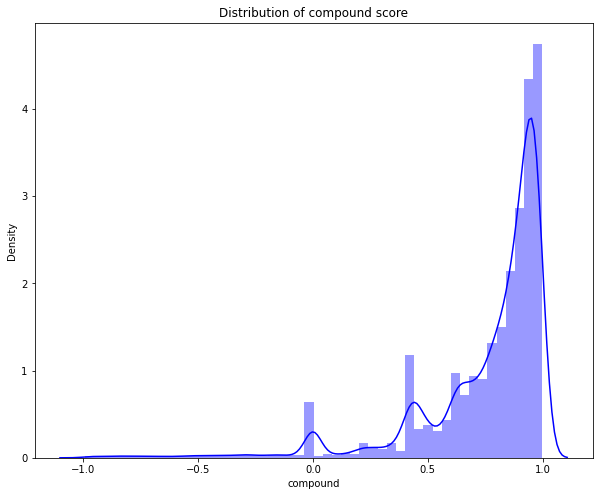

In [15]:
plt.figure(figsize = (10,8))
sns.distplot(reviews['compound'], norm_hist=True, color='blue')
plt.title('Distribution of compound score');

## Listings EDA

In [16]:
listings.head()

id                          listing_url       scrape_id last_scraped  \
0   50646   https://www.airbnb.com/rooms/50646  20211226165704   2021-12-27   
1   71609   https://www.airbnb.com/rooms/71609  20211226165704   2021-12-27   
2   71896   https://www.airbnb.com/rooms/71896  20211226165704   2021-12-27   
3   71903   https://www.airbnb.com/rooms/71903  20211226165704   2021-12-27   
4  275343  https://www.airbnb.com/rooms/275343  20211226165704   2021-12-27   

                                               name  \
0                   Pleasant Room along Bukit Timah   
1               Ensuite Room (Room 1 & 2) near EXPO   
2                   B&B  Room 1 near Airport & EXPO   
3                        Room 2-near Airport & EXPO   
4  Conveniently located City Room!(1,2,3,4,5,6,7,8)   

                                         description  \
0  Fully furnished bedroom with a nice view on th...   
1  For 3 rooms.Book room 1&2 and room 4<br /><br ...   
2  <b>The space</b><br />Vocational Stay Deluxe B...   
3  Like your own home, 24hrs access.<br /><br /><...   
4  Awesome location and host <br />Room near INSE...   

                               neighborhood_overview  \
0  The serenity & quiet surrounding makes it an i...   
1                                                NaN   
2                                                NaN   
3  Quiet and view of the playground with exercise...   
4                                                NaN   

                                         picture_url  host_id  \
0  https://a0.muscache.com/pictures/36342984/670d...   227796   
1  https://a0.muscache.com/pictures/24453191/3580...   367042   
2  https://a0.muscache.com/pictures/2440674/ac4f4...   367042   
3  https://a0.muscache.com/pictures/568743/7bc623...   367042   
4  https://a0.muscache.com/pictures/11979330/9bbd...  1439258   

                                    host_url host_name  host_since  \
0   https://www.airbnb.com/users/show/227796   Sujatha  2010-09-08   
1   https://www.airbnb.com/users/show/367042   Belinda  2011-01-29   
2   https://www.airbnb.com/users/show/367042   Belinda  2011-01-29   
3   https://www.airbnb.com/users/show/367042   Belinda  2011-01-29   
4  https://www.airbnb.com/users/show/1439258     Joyce  2011-11-24   

          host_location                                         host_about  \
0  Singapore, Singapore  I am a working professional, living in Singapo...   
1             Singapore  Hi My name is Belinda -Housekeeper \r\n\r\nI w...   
2             Singapore  Hi My name is Belinda -Housekeeper \r\n\r\nI w...   
3             Singapore  Hi My name is Belinda -Housekeeper \r\n\r\nI w...   
4  Singapore, Singapore  K2 Guesthouse is designed for guests who want ...   

   host_response_time host_response_rate host_acceptance_rate  \
0                 NaN                NaN                  NaN   
1        within a day               100%                  NaN   
2        within a day               100%                  NaN   
3        within a day               100%                  NaN   
4  within a few hours                87%                  77%   

  host_is_superhost                                 host_thumbnail_url  \
0                 f  https://a0.muscache.com/im/pictures/user/8fd2c...   
1                 f  https://a0.muscache.com/im/users/367042/profil...   
2                 f  https://a0.muscache.com/im/users/367042/profil...   
3                 f  https://a0.muscache.com/im/users/367042/profil...   
4                 f  https://a0.muscache.com/im/pictures/user/dad35...   

                                    host_picture_url host_neighbourhood  \
0  https://a0.muscache.com/im/pictures/user/8fd2c...        Bukit Timah   
1  https://a0.muscache.com/im/users/367042/profil...           Tampines   
2  https://a0.muscache.com/im/users/367042/profil...           Tampines   
3  https://a0.muscache.com/im/users/367042/profil...           Tampines   
4  https://a0.muscache.com/im/pictu

In [17]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3672 entries, 0 to 3671
Data columns (total 74 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            3672 non-null   int64  
 1   listing_url                                   3672 non-null   object 
 2   scrape_id                                     3672 non-null   int64  
 3   last_scraped                                  3672 non-null   object 
 4   name                                          3672 non-null   object 
 5   description                                   3555 non-null   object 
 6   neighborhood_overview                         2373 non-null   object 
 7   picture_url                                   3672 non-null   object 
 8   host_id                                       3672 non-null   int64  
 9   host_url                                      3672 non-null   o

In [18]:
# Removing '$' from price

listings['price'] = listings['price'].map(lambda price: price.replace('$',''))
listings['price'] = listings['price'].map(lambda price: price.replace(',',''))
listings['price'] = listings['price'].astype('float64')
listings['price']

0        80.0
1       179.0
2        82.0
3        82.0
4        52.0
        ...  
3667    185.0
3668    215.0
3669     48.0
3670    529.0
3671    224.0
Name: price, Length: 3672, dtype: float64

In [19]:
# Converting 'host_is_superhost' to 0 if 'f' and 1 if 't'

listings['host_is_superhost'] = listings['host_is_superhost'].map(lambda x: 1 if x == 't' else 0 )
listings['host_is_superhost'] = listings['host_is_superhost'].astype('int64')
listings['host_is_superhost']

0       0
1       0
2       0
3       0
4       0
       ..
3667    0
3668    0
3669    0
3670    0
3671    0
Name: host_is_superhost, Length: 3672, dtype: int64

In [20]:
listings['host_is_superhost'].value_counts()

0    2867
1     805
Name: host_is_superhost, dtype: int64

In [21]:
listings['beds'].value_counts()

1.0     2273
2.0      664
3.0      285
4.0      164
6.0       40
5.0       29
8.0       19
10.0      19
16.0      19
12.0      11
7.0        6
14.0       4
13.0       2
9.0        2
28.0       1
46.0       1
20.0       1
32.0       1
36.0       1
Name: beds, dtype: int64

In [22]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3672 entries, 0 to 3671
Data columns (total 74 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            3672 non-null   int64  
 1   listing_url                                   3672 non-null   object 
 2   scrape_id                                     3672 non-null   int64  
 3   last_scraped                                  3672 non-null   object 
 4   name                                          3672 non-null   object 
 5   description                                   3555 non-null   object 
 6   neighborhood_overview                         2373 non-null   object 
 7   picture_url                                   3672 non-null   object 
 8   host_id                                       3672 non-null   int64  
 9   host_url                                      3672 non-null   o

Select from listings.csv all the columns with individual (accuracy, cleanliness, checkin, communication, location, & value) and overall (rating) scores. Include 'id' column to merge with other DataFrames, and neighbourhood for later analysis.


In [23]:
# Taking relevant columns for EDA with polarity

listings1 = listings[['id', 'host_is_superhost', 'bedrooms','beds', 'review_scores_rating', 
                      'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin',
                      'review_scores_communication', 'review_scores_location', 'review_scores_value']]

In [24]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35706 entries, 0 to 35705
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   listing_id     35706 non-null  int64  
 1   id             35706 non-null  int64  
 2   date           35706 non-null  object 
 3   reviewer_id    35706 non-null  int64  
 4   reviewer_name  35706 non-null  object 
 5   comments       35706 non-null  object 
 6   language       35706 non-null  object 
 7   scores         35706 non-null  object 
 8   compound       35706 non-null  float64
dtypes: float64(1), int64(3), object(5)
memory usage: 2.5+ MB


In [25]:
listings.isnull().sum()

id                                                 0
listing_url                                        0
scrape_id                                          0
last_scraped                                       0
name                                               0
                                                ... 
calculated_host_listings_count                     0
calculated_host_listings_count_entire_homes        0
calculated_host_listings_count_private_rooms       0
calculated_host_listings_count_shared_rooms        0
reviews_per_month                               1628
Length: 74, dtype: int64

In [26]:
list_pol = pd.DataFrame(reviews.groupby(['listing_id']).mean()['compound'])
list_pol

compound
listing_id          
50646       0.919776
71609       0.693888
71896       0.854124
71903       0.608390
275343      0.781355
...              ...
53388036    0.801200
53408171    0.700300
53614218    0.955500
53679344    0.920100
53717759    0.717800

[1912 rows x 1 columns]

In [27]:
# Merging listings1 and list_pol on common 'id'
combined = pd.merge(listings1, list_pol, left_on = 'id', right_on = 'listing_id', how = 'left')
combined

id  host_is_superhost  bedrooms  beds  review_scores_rating  \
0        50646                  0       1.0   1.0                  4.56   
1        71609                  0       2.0   3.0                  4.44   
2        71896                  0       1.0   1.0                  4.16   
3        71903                  0       1.0   2.0                  4.41   
4       275343                  0       1.0   1.0                  4.39   
...        ...                ...       ...   ...                   ...   
3667  53905492                  0       1.0   2.0                   NaN   
3668  53905653                  0       1.0   2.0                   NaN   
3669  53910005                  0       1.0   1.0                   NaN   
3670  53910434                  0       2.0   3.0                   NaN   
3671  53927825                  0       1.0   1.0                   NaN   

      review_scores_accuracy  review_scores_cleanliness  \
0                       4.72                       4.78   
1                       4.37                       4.00   
2                       4.22                       4.09   
3                       4.39                       4.52   
4                       4.12                       4.24   
...                      ...                        ...   
3667                     NaN                        NaN   
3668                     NaN                        NaN   
3669                     NaN                        NaN   
3670                     NaN                        NaN   
3671                     NaN                        NaN   

      review_scores_checkin  review_scores_communication  \
0                      4.78                         4.94   
1                      4.63                         4.78   
2                      4.43                         4.43   
3                      4.63                         4.64   
4                      4.53                         4.47   
...                     ...                          ...   
3667                    NaN                          NaN   
3668                    NaN                          NaN   
3669                    NaN                          NaN   
3670                    NaN                          NaN   
3671                    NaN                          NaN   

      review_scores_location  review_scores_value  compound  
0                       4.72                 4.50  0.919776  
1                       4.26                 4.32  0.693888  
2                       4.17                 4.04  0.854124  
3                       4.50                 4.36  0.608390  
4                       4.53                 4.59  0.781355  
...                      ...                  ...       ...  
3667                     NaN                  NaN       NaN  
3668                     NaN                  NaN       NaN  
3669                     NaN                  NaN       NaN  
3670                     NaN                  NaN       NaN  
3671                     NaN                  NaN       NaN  

[3672 rows x 12 columns]

In [28]:
combined.isnull().sum()

id                                0
host_is_superhost                 0
bedrooms                        417
beds                            130
review_scores_rating           1628
review_scores_accuracy         1684
review_scores_cleanliness      1683
review_scores_checkin          1684
review_scores_communication    1683
review_scores_location         1684
review_scores_value            1684
compound                       1760
dtype: int64

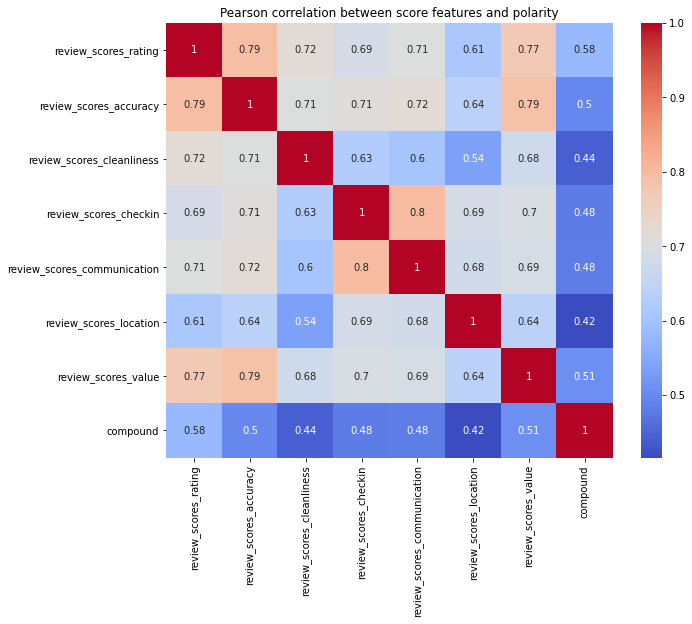

In [29]:
review_scores = ['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 
                 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 
                 'review_scores_value', 'compound']

plt.figure(figsize = (10,8))
corr = combined[review_scores].corr()

sns.heatmap(corr, annot=True, cmap = 'coolwarm')
plt.title('Pearson correlation between score features and polarity');

### Cosine Similarity (Content based)

In [30]:
combined.index = combined['id']
combined.drop('id', axis = 1, inplace = True)
combined = combined.fillna(0)
combined

host_is_superhost  bedrooms  beds  review_scores_rating  \
id                                                                  
50646                     0       1.0   1.0                  4.56   
71609                     0       2.0   3.0                  4.44   
71896                     0       1.0   1.0                  4.16   
71903                     0       1.0   2.0                  4.41   
275343                    0       1.0   1.0                  4.39   
...                     ...       ...   ...                   ...   
53905492                  0       1.0   2.0                  0.00   
53905653                  0       1.0   2.0                  0.00   
53910005                  0       1.0   1.0                  0.00   
53910434                  0       2.0   3.0                  0.00   
53927825                  0       1.0   1.0                  0.00   

          review_scores_accuracy  review_scores_cleanliness  \
id                                                            
50646                       4.72                       4.78   
71609                       4.37                       4.00   
71896                       4.22                       4.09   
71903                       4.39                       4.52   
275343                      4.12                       4.24   
...                          ...                        ...   
53905492                    0.00                       0.00   
53905653                    0.00                       0.00   
53910005                    0.00                       0.00   
53910434                    0.00                       0.00   
53927825                    0.00                       0.00   

          review_scores_checkin  review_scores_communication  \
id                                                             
50646                      4.78                         4.94   
71609                      4.63                         4.78   
71896                      4.43                         4.43   
71903                      4.63                         4.64   
275343                     4.53                         4.47   
...                         ...                          ...   
53905492                   0.00                         0.00   
53905653                   0.00                         0.00   
53910005                   0.00                         0.00   
53910434                   0.00                         0.00   
53927825                   0.00                         0.00   

          review_scores_location  review_scores_value  compound  
id                                                               
50646                       4.72                 4.50  0.919776  
71609                       4.26                 4.32  0.693888  
71896                       4.17                 4.04  0.854124  
71903                       4.50                 4.36  0.608390  
275343                      4.53                 4.59  0.781355  
...                          ...                  ...       ...  
53905492                    0.00                 0.00  0.000000  
53905653                    0.00                 0.00  0.000000  
53910005                    0.00                 0.00  0.000000  
53910434                    0.00                 0.00  0.000000  
53927825                    0.00                 0.00  0.000000  

[3672 rows x 11 columns]

#### Listing based

In [31]:
df1 = pd.DataFrame(cosine_similarity(combined.fillna(0)), columns = combined.index, index = combined.index)
df1

id        50646     71609     71896     71903     275343    275344    \
id                                                                     
50646     1.000000  0.980662  0.999645  0.995908  0.998722  0.999200   
71609     0.980662  1.000000  0.983627  0.992077  0.981979  0.981955   
71896     0.999645  0.983627  1.000000  0.996498  0.998908  0.999527   
71903     0.995908  0.992077  0.996498  1.000000  0.995913  0.995739   
275343    0.998722  0.981979  0.998908  0.995913  1.000000  0.999122   
...            ...       ...       ...       ...       ...       ...   
53905492  0.106551  0.292717  0.118803  0.184587  0.113827  0.110551   
53905653  0.106551  0.292717  0.118803  0.184587  0.113827  0.110551   
53910005  0.112315  0.289267  0.125229  0.175114  0.119984  0.116531   
53910434  0.110134  0.294995  0.122797  0.183161  0.117654  0.114268   
53927825  0.112315  0.289267  0.125229  0.175114  0.119984  0.116531   

id        294281    324945    330089    330095    344803    355955    \
id                                                                     
50646     0.999339  0.999194  0.996330  0.998037  0.999326  0.112315   
71609     0.982731  0.982079  0.971587  0.980660  0.981594  0.289267   
71896     0.999617  0.999306  0.995818  0.998525  0.999413  0.125229   
71903     0.996102  0.996178  0.992564  0.994633  0.996224  0.175114   
275343    0.999539  0.998364  0.994969  0.998265  0.999202  0.119984   
...            ...       ...       ...       ...       ...       ...   
53905492  0.113382  0.116509  0.072964  0.103535  0.109992  0.948683   
53905653  0.113382  0.116509  0.072964  0.103535  0.109992  0.948683   
53910005  0.119515  0.122811  0.057683  0.109135  0.115942  1.000000   
53910434  0.117194  0.120426  0.067875  0.107016  0.113691  0.980581   
53927825  0.119515  0.122811  0.057683  0.109135  0.115942  1.000000   

id        369141    369145    395191    481789    604966    606784    \
id                                                                     
50646     0.999613  0.999156  0.998980  0.112315  0.993690  0.999619   
71609     0.981875  0.982655  0.982602  0.289267  0.985520  0.980728   
71896     0.999687  0.999588  0.999541  0.125229  0.995714  0.999555   
71903     0.996124  0.995991  0.995701  0.175114  0.990597  0.995793   
275343    0.999620  0.999366  0.998878  0.119984  0.994599  0.998650   
...            ...       ...       ...       ...       ...       ...   
53905492  0.110032  0.113102  0.113755  0.948683  0.144280  0.104877   
53905653  0.110032  0.113102  0.113755  0.948683  0.144280  0.104877   
53910005  0.115984  0.119220  0.119908  1.000000  0.171095  0.110550   
53910434  0.113732  0.116905  0.117580  0.980581  0.156588  0.108403   
53927825  0.115984  0.119220  0.119908  1.000000  0.171095  0.110550   

id        642660    696136    733863    747813    747816    756267    \
id                                                                     
50646     0.112315  0.999200  0.112315  0.999590  0.998952  0.996636   
71609     0.289267  0.981045  0.289267  0.980909  0.981207  0.977567   
71896     0.125229  0.999207  0.125229  0.999364  0.999110  0.996454   
71903     0.175114  0.995767  0.175114  0.995967  0.995414  0.992846   
275343    0.119984  0.999388  0.119984  0.999126  0.998689  0.996153   
...            ...       ...       ...       ...       ...       ...   
53905492  0.948683  0.109186  0.948683  0.107288  0.109100  0.105562   
53905653  0.948683  0.109186  0.948683  0.107288  0.109100  0.105562   
53910005  1.000000  0.115093  1.000000  0.113092  0.115001  0.111272   
53910434  0.980581  0.112857  0.980581  0.110895  0.112768  0.109112   
53927825  1.000000  0.115093  1.000000  0.113092  0.115001  0.111272   

id        765579    815685    819034    819044    823571    833289    \
id                                                                     
50646     0.988745  0.999342  0.990871  0.996642  0.112315  0.997057   
71609     0.979088  0.983061  0.9909

In [32]:
df1.describe()

id        50646        71609        71896        71903        275343    \
count  3672.000000  3672.000000  3672.000000  3672.000000  3672.000000   
mean      0.577697     0.650867     0.583430     0.607761     0.580918   
std       0.439371     0.353143     0.433783     0.408793     0.435873   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.112315     0.289267     0.125229     0.175114     0.119984   
50%       0.950448     0.963671     0.954156     0.965953     0.952484   
75%       0.996226     0.979752     0.996037     0.993267     0.995539   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

id        275344       294281       324945       330089       330095    \
count  3672.000000  3672.000000  3672.000000  3672.000000  3672.000000   
mean      0.579590     0.580920     0.582002     0.555303     0.575865   
std       0.437562     0.436272     0.434501     0.459380     0.440358   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.116531     0.119515     0.122811     0.057683     0.109135   
50%       0.951658     0.952486     0.952796     0.937699     0.948844   
75%       0.996111     0.995969     0.995353     0.993495     0.995481   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

id        344803       355955       369141       369145       395191    \
count  3672.000000  3672.000000  3672.000000  3672.000000  3672.000000   
mean      0.579474     0.506609     0.579393     0.580745     0.580866   
std       0.437946     0.397960     0.437843     0.436359     0.435894   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.115942     0.112253     0.115984     0.119220     0.119908   
50%       0.951898     0.338254     0.951814     0.952542     0.952146   
75%       0.996262     1.000000     0.996142     0.995745     0.995357   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

id        481789       604966       606784       642660       696136    \
count  3672.000000  3672.000000  3672.000000  3672.000000  3672.000000   
mean      0.506609     0.597493     0.576935     0.506609     0.578789   
std       0.397960     0.413898     0.440152     0.397960     0.438028   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.112253     0.171095     0.110550     0.112253     0.115093   
50%       0.338254     0.949883     0.949955     0.338254     0.950980   
75%       1.000000     0.990747     0.996360     1.000000     0.995573   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

id        733863       747813       747816       756267       765579    \
count  3672.000000  3672.000000  3672.000000  3672.000000  3672.000000   
mean      0.506609     0.578167     0.578696     0.578979     0.585575   
std       0.397960     0.439141     0.438016     0.436909     0.420993   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.112253     0.113092     0.115001     0.111272     0.142741   
50%       0.338254     0.950971     0.951399     0.947982     0.946597   
75%       1.000000     0.996196     0.995368     0.995338     0.984756   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

id        815685       819034       819044       823571       833289    \
count  3672.000000  3672.000000  3672.000000  3672.000000  3672.000000   
mean      0.583838     0.623030     0.579418     0.506609     0.600278   
std       0.432794     0.388960     0.436259     0.397960     0.416930   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.126840     0.216710     0.112473     0.112253     0.157836   
50%       0.953793     0.961063     0.948462     0.338254     0.962396   
75%       0.995368     0.990669     0.995068     1.000000     0.994403   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

In [33]:
df1[50646].sort_values(ascending = False).head(10)

id
50646       1.000000
16891958    0.999865
29020376    0.999860
31960343    0.999850
7681974     0.999838
6831622     0.999837
24238015    0.999827
21888054    0.999820
6300577     0.999810
26683920    0.999810
Name: 50646, dtype: float64

#### Profile based

In [37]:
features = combined.columns.tolist()
user_profile = pd.Series(np.zeros(len(features)), index=combined.columns)

# user_profile['price'] = 150
user_profile['bedrooms'] = 1
user_profile['review_scores_rating'] = 4
user_profile['review_scores_cleanliness'] = 4

recommendations = np.dot(combined.values, user_profile.values)
print(recommendations)
recommendations = pd.Series(recommendations, index = combined.index)
recommendations

[38.36 35.76 34.   ...  1.    2.    1.  ]


id
50646       38.36
71609       35.76
71896       34.00
71903       36.72
275343      35.52
            ...  
53905492     1.00
53905653     1.00
53910005     1.00
53910434     2.00
53927825     1.00
Length: 3672, dtype: float64

In [38]:
len(recommendations)

3672

In [60]:
recommender = pd.DataFrame(recommendations, columns = ['dot product'])
recommender.sort_values('dot product', ascending = False).head(10)

dot product
id                   
18492050        44.00
35788857        43.68
33112080        43.32
4833408         43.28
33112676        43.12
36156663        43.00
44069414        43.00
37257081        43.00
31725137        43.00
40927431        43.00

In [ ]:
recommender

In [40]:
combined.loc[18492050]

host_is_superhost              0.0000
bedrooms                       4.0000
beds                           3.0000
review_scores_rating           5.0000
review_scores_accuracy         5.0000
review_scores_cleanliness      5.0000
review_scores_checkin          5.0000
review_scores_communication    5.0000
review_scores_location         5.0000
review_scores_value            5.0000
compound                       0.8977
Name: 18492050, dtype: float64

In [53]:
reviews[reviews['listing_id'] == 18492050]

listing_id         id        date  reviewer_id reviewer_name  \
20701    18492050  240528899  2018-03-05     88176642         Filip   

                                                comments language  \
20701  An oasis of tranquillity. Very spacious apartm...       en   

                                                  scores  compound  
20701  {'neg': 0.0, 'neu': 0.544, 'pos': 0.456, 'comp...    0.8977

In [56]:
reviews[reviews['listing_id'] == 35788857]

listing_id                  id        date  reviewer_id reviewer_name  \
31875    35788857           475280814  2019-06-24    270298898    Richardson   
31876    35788857           484996714  2019-07-10     54297973      Veronica   
31877    35788857           491968784  2019-07-21    157324648          Eric   
31878    35788857           523172034  2019-09-03    166513853           Jay   
31879    35788857           525486412  2019-09-08    115268197            태경   
31880    35788857           527483147  2019-09-11     92571742        Khodee   
31881    35788857           532070209  2019-09-19       463171        Martin   
31882    35788857           535260159  2019-09-24    255489556        Nguyen   
31883    35788857           540719614  2019-10-04    107940634        Daniel   
31884    35788857           554254909  2019-10-26    100128423         Danny   
31885    35788857           556238627  2019-10-29    213508045        Jasper   
31886    35788857           557869271  2019-11-02     97420191          Cara   
31887    35788857           559405761  2019-11-04    283883650     Jackerson   
31888    35788857           567217185  2019-11-22     13222696        Markku   
31889    35788857           575393375  2019-12-10     87617665        Hayden   
31890    35788857           583683734  2019-12-29    310624370          Musa   
31891    35788857           588735907  2020-01-05    204197300     Christine   
31892    35788857           591781396  2020-01-12    162193423         Fajar   
31893    35788857           600570514  2020-02-02    313078612     Phimchada   
31894    35788857           617827472  2020-03-14     23839644       Rachael   
31895    35788857           618946854  2020-03-16    326391437           Jon   
31896    35788857           621191256  2020-03-29     95888293      Ignatius   
31897    35788857           622449489  2020-04-15    104592126       Rasidah   
31898    35788857           628427661  2020-06-08    344973553         Abbas   
31899    35788857           631380715  2020-06-22    229243540       Juraimi   
31900    35788857           641250836  2020-07-23    351462180         Iouri   
31901    35788857  443730721119084707  2021-09-04    404163123        Faatin   

                                                comments language  \
31875  Wonderful holiday trip. Less than  mins walk t...       en   
31876  Perfect place for family trip. The apartment i...       en   
31877  Excellent host, excellent place, incredibly cl...       en   
31878  Highly recommend! Extremely clean with great a...       en   
31879  The area is a little bit not family-friendly a...       en   
31880  We loved staying at J's place!It was incredibl...       en   
31881  Clean, comfortable and spacious this apartment...       en   
31882  The bus station is not really far from the hou...       en   
31883                                   Had a great time       en   
31884  Very clean and spacious place with good amenit...       en   
31885                            Perfect and Clean Place       en   
31886  This place was amazing! It was super easy to c...       en   
31887  Highly recommended for Singapore stay that are...       en   
31888  Awesome apartment, great location! Everything ...       en   
31889  Great size for large families, very modern and...       en   
31890  Great apartments. Super  clean with everything...       en   
31891  Very good place, very convenience location, wi...       en   
31892  Neat, clean, cozy, complete, definitely you wo...       en   
31893  Great place and big space. Host was a kind per...       en   
31894                                          No thanks       en   
31895  No doubt it is the best choice if you have a b...       en   
31896  First of all, the apartment is very clean and ...       en   
31897  The place is worth the money and comfortable a...       en   
31898  Awesome host and very accommodative to my fami...       en   
31899  The place is really awesome. Worth

In [55]:
listings[listings['id'] == 18492050]

id                            listing_url       scrape_id  \
849  18492050  https://www.airbnb.com/rooms/18492050  20211226165704   

    last_scraped                                     name  \
849   2021-12-26  3 bed Ground Floor Apt 2,700sf, Central   

                                           description neighborhood_overview  \
849  Large ground floor apt in lowrise block in gen...                   NaN   

                                           picture_url  host_id  \
849  https://a0.muscache.com/pictures/5e88b6f1-8b2c...  4367042   

                                      host_url host_name  host_since  \
849  https://www.airbnb.com/users/show/4367042    Yvonne  2012-12-09   

    host_location host_about  host_response_time host_response_rate  \
849     Singapore        NaN  a few days or more                 0%   

    host_acceptance_rate  host_is_superhost  \
849                  NaN                  0   

                                    host_thumbnail_url  \
849  https://a0.muscache.com/im/users/4367042/profi...   

                                      host_picture_url host_neighbourhood  \
849  https://a0.muscache.com/im/users/4367042/profi...        Bukit Timah   

     host_listings_count  host_total_listings_count  \
849                  1.0                        1.0   

                host_verifications host_has_profile_pic  \
849  ['email', 'phone', 'reviews']                    t   

    host_identity_verified neighbourhood neighbourhood_cleansed  \
849                      f           NaN            Bukit Timah   

    neighbourhood_group_cleansed  latitude  longitude  \
849               Central Region   1.32979  103.81148   

                  property_type        room_type  accommodates  bathrooms  \
849  Entire condominium (condo)  Entire home/apt             6        NaN   

    bathrooms_text  bedrooms  beds  \
849      4.5 baths       4.0   3.0   

                                             amenities  price  minimum_nights  \
849  ["Essentials", "Kitchen", "Long term stays all...  350.0             180   

     maximum_nights  minimum_minimum_nights  maximum_minimum_nights  \
849             364                   180.0                   180.0   

     minimum_maximum_nights  maximum_maximum_nights  minimum_nights_avg_ntm  \
849                  1125.0                  1125.0                   180.0   

     maximum_nights_avg_ntm  calendar_updated has_availability  \
849                  1125.0               NaN                t   

     availability_30  availability_60  availability_90  availability_365  \
849               30               60               90               271   

    calendar_last_scraped  number_of_reviews  number_of_reviews_ltm  \
849            2021-12-26                  1                      0   

     number_of_reviews_l30d first_review last_review  review_scores_rating  \
849                       0   2018-03-05  2018-03-05                   5.0   

     review_scores_accuracy  review_scores_cleanliness  review_scores_checkin  \
849                     5.0                        5.0                    5.0   

     review_scores_communication  review_scores_location  review_scores_value  \
849                          5.0                     5.0                  5.0   

    license instant_bookable  calculated_host_listings_count  \
849     NaN                t                               1   

     calculated_host_listings_count_entire_homes  \
849                                            1   

     calculated_host_listings_count_private_rooms  \
849                                             0   

     calculated_host_listings_count_shared_rooms  reviews_per_month  
849                                            0               0.02

In [57]:
listings[listings['id'] == 35788857]

id                            listing_url       scrape_id  \
1972  35788857  https://www.airbnb.com/rooms/35788857  20211226165704   

     last_scraped                                         name  \
1972   2021-12-26  [702] 超大4房 Super Spacious with free parking   

                                            description  \
1972  Geylang still reigns as a popular buzzing food...   

                                  neighborhood_overview  \
1972  Foodie’s Paradise, Nightlife, Multiculturalism...   

                                            picture_url    host_id  \
1972  https://a0.muscache.com/pictures/494f2daf-5bfa...  268956734   

                                         host_url host_name  host_since  \
1972  https://www.airbnb.com/users/show/268956734      Wang  2019-06-16   

             host_location host_about host_response_time host_response_rate  \
1972  Singapore, Singapore   I'm Wang     within an hour               100%   

     host_acceptance_rate  host_is_superhost  \
1972                  74%                  1   

                                     host_thumbnail_url  \
1972  https://a0.muscache.com/im/pictures/user/bc1e7...   

                                       host_picture_url host_neighbourhood  \
1972  https://a0.muscache.com/im/pictures/user/bc1e7...            Geylang   

      host_listings_count  host_total_listings_count  \
1972                 15.0                       15.0   

                                     host_verifications host_has_profile_pic  \
1972  ['email', 'phone', 'jumio', 'offline_governmen...                    t   

     host_identity_verified         neighbourhood neighbourhood_cleansed  \
1972                      t  Singapore, Singapore                Geylang   

     neighbourhood_group_cleansed  latitude  longitude  \
1972               Central Region    1.3119  103.87954   

                   property_type        room_type  accommodates  bathrooms  \
1972  Entire condominium (condo)  Entire home/apt            12        NaN   

     bathrooms_text  bedrooms  beds  \
1972        3 baths       4.0   5.0   

                                              amenities  price  \
1972  ["Hangers", "Washer", "Carbon monoxide alarm",...  505.0   

      minimum_nights  maximum_nights  minimum_minimum_nights  \
1972               4            1000                     2.0   

      maximum_minimum_nights  minimum_maximum_nights  maximum_maximum_nights  \
1972                     4.0                  1000.0                  1000.0   

      minimum_nights_avg_ntm  maximum_nights_avg_ntm  calendar_updated  \
1972                     4.0                  1000.0               NaN   

     has_availability  availability_30  availability_60  availability_90  \
1972                t                0               29               59   

      availability_365 calendar_last_scraped  number_of_reviews  \
1972                60            2021-12-26                 47   

      number_of_reviews_ltm  number_of_reviews_l30d first_review last_review  \
1972                      1                       0   2019-06-24  2021-09-04   

      review_scores_rating  review_scores_accuracy  review_scores_cleanliness  \
1972                  4.96                    4.96                       4.96   

      review_scores_checkin  review_scores_communication  \
1972                   4.96                         4.96   

      review_scores_location  review_scores_value license instant_bookable  \
1972                     4.7                 4.72     NaN                f   

      calculated_host_listings_count  \
1972                              15   

      calculated_host_listings_count_entire_homes  \
1972                                           15   

      calculated_host_listings_count_private_rooms  \
1972                                             0   

      calculated_host_listings_count_shared_rooms  reviews_per_month  
1972                                            0           

### Collaborative based